In [24]:
import math
from top2vec import Top2Vec
import numpy as np
import pandas as pd
import umap
from csv import writer
#import umap.plot
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [38]:
file = 'top2vec_umap_n_n15_hdbscan_m_c_s15_doc2vec_new' #_NOV_COL_MEM_VER
#file = 'top2vec_original_setting_new_NOV_COL_MEM_VER'
fiction = False
folder = 'whole books  NOV COL MEM VER' if fiction else 'whole books'
file_ending = "_NOV_COL_MEM_VER" if fiction else ''
file = file+file_ending

df_path = 'data/results/top2vec/{folder}/{file}.xlsx'.format(folder = folder, file = file) #  NOV COL MEM VER
model_path = 'models/{folder}/top2vec/{file}'.format(folder = folder, file = file) #  NOV COL MEM VER
#df = pd.read_excel(df_path)
## Load the model
top2vec_model = Top2Vec.load(model_path)

In [36]:
from collections import defaultdict

# Number of clusters
topic_sizes, topic_nums_original = top2vec_model.get_topic_sizes()

documents_topics = {}

for topic_num in topic_nums_original: 

        # Get documents that are part of the topic
        documents, document_scores, document_ids = top2vec_model.search_documents_by_topic(topic_num=topic_num, num_docs=1)

        documents_topics[document_ids[0]] = [topic_num]

# Reduce clusters
for i in reversed(range(2, max(topic_nums_original)+1)):
    ret = top2vec_model.hierarchical_topic_reduction(num_topics=i)

    print(ret)

#     topic_sizes, topic_nums = top2vec_model.get_topic_sizes()
 
#     for key in documents_topics.keys():
            
#             topic, _, _, _ = top2vec_model.get_documents_topics(doc_ids = [key], reduced = True)

#             documents_topics[key].append(topic[0])    

print([f'{key}: {documents_topics[key][0]}' for key in documents_topics.keys()])  
print(documents_topics.keys())    



[[0], [5, 1], [2], [3], [4]]
[[4, 5, 1], [0], [2], [3]]
[[4, 5, 1], [3, 0], [2]]
[[2, 3, 0], [4, 5, 1]]
['319: 0', '194: 1', '475: 2', '112: 3', '99: 4', '596: 5']
dict_keys([319, 194, 475, 112, 99, 596])


KeyError: 24

In [25]:
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt


mat = np.array([[0.0, 2.0, 0.1], [2.0, 0.0, 2.0], [0.1, 2.0, 0.0]])
dists = squareform(mat)
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, labels=["0", "1", "2"])
plt.title("test")
plt.show()


array([], dtype=float64)

In [5]:
ret = top2vec_model.hierarchical_topic_reduction(2)
print(ret)

[[9, 16, 4, 12, 14, 15, 11, 6, 13, 10, 7, 8, 2], [1, 3, 5, 0]]


/Users/charlottepanuskova/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/var/folders/sq/pxhs33t53bz1x33q9fhn04w00000gn/T/ipykernel_35618/1944642216.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, 'average')


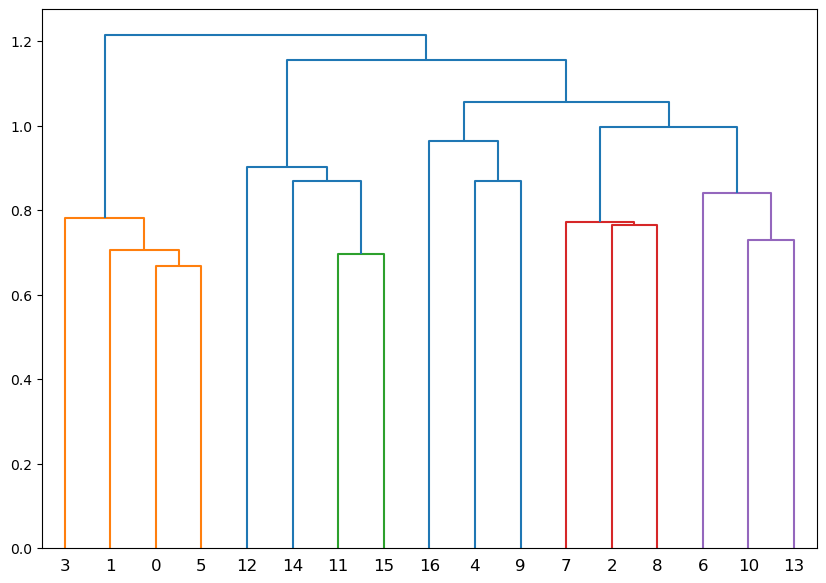

In [39]:
topic_embeddings = top2vec_model.topic_vectors
distance_matrix = cosine_distances(topic_embeddings)

# hierarchical clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='precomputed', linkage='average')
clustering_model.fit(distance_matrix)

linked = linkage(distance_matrix, 'average')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.show()

labels = clustering_model.labels_


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Assume `top2vec_model` is your trained Top2Vec model

def collect_linkage_during_reduction(model, num_topics):
    merge_history = []
    top_vecs = model.topic_vectors
    top_sizes = [model.topic_sizes[i] for i in range(len(model.topic_sizes))]
    
    current_cluster_id = len(top_vecs)
    cluster_map = {i: i for i in range(len(top_vecs))}  # Maps old indices to new indices
    
    while len(top_vecs) > num_topics:
        smallest = np.argmin(top_sizes)
        res = np.inner(top_vecs[smallest], top_vecs)
        sims = np.flip(np.argsort(res))
        most_sim = sims[1]
        if most_sim == smallest:
            most_sim = sims[0]

        distance = 1 - res[most_sim]

        # Append merge data: [index1, index2, distance, new cluster size]
        merge_history.append([
            min(cluster_map[smallest], cluster_map[most_sim]),
            max(cluster_map[smallest], cluster_map[most_sim]),
            distance,
            top_sizes[smallest] + top_sizes[most_sim]
        ])

        # Merge clusters
        top_vec_smallest = top_vecs[smallest]
        smallest_size = top_sizes[smallest]

        top_vec_most_sim = top_vecs[most_sim]
        most_sim_size = top_sizes[most_sim]

        combined_vec = model._l2_normalize(((top_vec_smallest * smallest_size) +
                                            (top_vec_most_sim * most_sim_size)) / (smallest_size + most_sim_size))

        # Remove old clusters and append the new one
        ix_keep = list(range(len(top_vecs)))
        ix_keep.remove(smallest)
        ix_keep.remove(most_sim)
        top_vecs = top_vecs[ix_keep]
        top_vecs = np.vstack([top_vecs, combined_vec])
        top_sizes.append(smallest_size + most_sim_size)
        top_sizes = [top_sizes[i] for i in ix_keep]
        
        # Update cluster map
        cluster_map[smallest] = current_cluster_id
        cluster_map[most_sim] = current_cluster_id
        
        current_cluster_id += 1
    
    return np.array(merge_history)

# Plotting the dendrogram
def plot_dendrogram(merge_history):
    plt.figure(figsize=(10, 7))
    dendrogram(merge_history, no_labels=True)
    plt.show()

# Usage
merge_history = collect_linkage_during_reduction(top2vec_model, num_topics=15)
plot_dendrogram(merge_history)


ValueError: Linkage 'Z' uses non-singleton cluster before it is formed.

<Figure size 1000x700 with 0 Axes>